In [64]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import norm


#################
# Test Bed 2-25 #
#################
# HS Analysis Functions

### Aux Functions for reading two different .csv files ###
def read_hs1(yoozer, hs1_file = "../../../Data/suggest-analysis-kristjan.csv"):
    pd_df = pd.read_csv(hs1_file) #'suggest-analysis-kristjan.csv')
    pdf = pd_df[:179]
    snda = pd_df['send.active'] == 1
    snd = pd_df['send'] == 0
    usr = pd_df['user'] == yoozer
    ddf = pd_df[(snda | snd) & usr]
    ddf = ddf.reset_index(drop=True)
    
    
    return ddf,pd_df

def read_hs1_gf(yoozer, hs1_gf_file = '../../../Data/suggest-kristjan.csv'):
    pd_df = pd.read_csv(hs1_gf_file) #'suggest-analysis-kristjan.csv')
    pdf = pd_df[:179]
    snda = pd_df['send.active'] == 1
    snd = pd_df['send'] == 0
    usr = pd_df['user'] == yoozer
    ddf = pd_df[(snda | snd) & usr]
    ddf = ddf.reset_index(drop=True)

    return ddf,pd_df


def nan_equal(a,b):
    return ((a == b) | (np.isnan(a) & np.isnan(b))).all()


def standardize_column(ddf, col_name):
    '''Standardizes column col_name in ddf inplace, converting to a float too'''
    ddf.loc[:,col_name] = ddf[col_name].astype(float)
    ddf.loc[:,col_name] = (ddf[col_name] - ddf[col_name].mean()) / ddf[col_name].std()


def read_data_slow(N, T, t, nBaseline, data_loc_pref = "C:/Users/isaac/Dropbox/Harvard 17-18 Senior/Thesis/Data/"):
    ### Read in Feature vector, Reward Vector, and Action Vector for each user ###
    # Also Standardizes all features

    max_yoozer = N+1

    featVec = np.empty((max_yoozer,T*t, nBaseline))
    featVec.fill(np.nan)

    rewardVec = np.empty((max_yoozer,T*t))
    rewardVec.fill(np.nan)

    actionVec = np.empty((max_yoozer,T*t))
    actionVec.fill(np.nan)

    for yoozer in range(1,max_yoozer):

        ddf,pd_df = read_hs1(yoozer, data_loc_pref + "suggest-analysis-kristjan.csv")
        #Make features
        
        #Center and scale
        decision_ind = ddf['decision.index.nogap']
        reward_h = ddf['jbsteps30.log']
        send_any = ddf['send']
        send_active = ddf['send.active']

        assert np.all(send_any == send_active)

        # Study day index
        dazze = ddf['study.day.nogap']

        # Number of messages sent in last week
        day_ind  = ddf['study.day.nogap'].astype(float)
        day_ind = (day_ind - np.mean(day_ind))/np.std(day_ind)

        # Ohter location indicator
        loc_ind = ddf['loc.is.other'].astype(float)
        loc_ind = (loc_ind - np.mean(loc_ind))/np.std(loc_ind)

        # Std deviation of step count in last 7 days
        steps_sd = ddf['window7.steps60.sd'].astype(float)
        steps_sd = (steps_sd - np.mean(steps_sd))/np.std(steps_sd)

        # Step count in previous 30 minutes
        state = ddf['jbsteps30pre.log'].astype(float)
        state = (state - np.mean(state))/np.std(state)
        
        # Work location indicator
        wrk_ind = ddf['loc.is.work'].astype(float) #compare to string “work”
        wrk_ind = (wrk_ind - np.mean(wrk_ind))/np.std(wrk_ind)

        # Square root steps yesterday
        steps_yest = ddf['steps.yesterday.sqrt'].astype(float)
        steps_yest = (steps_yest - np.mean(steps_yest))/np.std(steps_yest)

        # Temperature, set -1024 as 0
        temp = ddf['temperature'].astype(float)
        temp[ddf['temperature'] == -1024] = 0
        temp = (temp - np.mean(temp))/np.std(temp)
        

        ddfgf,pd_dfgf = read_hs1_gf(yoozer, data_loc_pref + "suggest-kristjan.csv")


        end_ind = day_ind.shape[0]


        # Set reward, action, and state
        rewardVec[yoozer,:end_ind] = reward_h.astype(float)
        actionVec[yoozer,:end_ind] = send_any.astype(float)

        featVec[yoozer,:end_ind,0].fill(1) # Only fill rows with observations
        featVec[yoozer,:end_ind,1] = day_ind #study.day.nogap
        featVec[yoozer,:end_ind,2] = loc_ind # loc.is.other
        featVec[yoozer,:end_ind,3] = steps_sd # window7.steps60.sd
        featVec[yoozer,:end_ind,4] = state # jbsteps30pre.log
        featVec[yoozer,:end_ind,5] = wrk_ind # loc.is.work
        featVec[yoozer,:end_ind,6] = steps_yest # steps.yesterday.sqrt
        featVec[yoozer,:end_ind,7] = temp # temperature

    
    ## TREAT DATA ##

    # Drop 0th user, since users are 1-indexed
    featVec = featVec[1:,:,:].copy()
    rewardVec = rewardVec[1:,:].copy()
    actionVec = actionVec[1:,:].copy()

    # Reshape actionVec to have additional 1 dim
    actionVec = actionVec.reshape(actionVec.shape[0],actionVec.shape[1],1)

    # Mean impute featVec where there is an observation
    featVec[~np.isnan(featVec[:,:,1])] = np.nan_to_num(featVec[~np.isnan(featVec[:,:,1])])
    
    
    # Drop users with no data
    rewardVec = rewardVec[~np.isnan(featVec).all(axis=(1,2))]
    actionVec = actionVec[~np.isnan(featVec).all(axis=(1,2))]
    featVec = featVec[~np.isnan(featVec).all(axis=(1,2))]
    
    return featVec, rewardVec, actionVec


def read_data(N, T, t, nBaseline, data_loc_pref):

    ddf = pd.read_csv(data_loc_pref + "suggest-analysis-kristjan.csv")
    # Filter for when either sent active message or no message at all, and relevant columns
    ddf = ddf.loc[(ddf["send.active"] == 1) | (ddf["send"] == 0),["user","study.day.nogap","loc.is.other","window7.steps60.sd","jbsteps30pre.log","loc.is.work","steps.yesterday.sqrt","temperature","send","send.active","jbsteps30.log"]]

    # Standardize columns
    standardize_column(ddf,"study.day.nogap")
    standardize_column(ddf,"loc.is.other")
    standardize_column(ddf,"window7.steps60.sd")
    standardize_column(ddf,"jbsteps30pre.log")
    standardize_column(ddf,"loc.is.work")
    standardize_column(ddf,"steps.yesterday.sqrt")
    ddf.loc[ddf["temperature"] == -1024,"temperature"] = np.nan # replace bad temperature measurement with null
    standardize_column(ddf,"temperature")
    ddf.loc[ddf["temperature"].isnull(),"temperature"] = ddf["temperature"].mean()


    featVec = np.empty((N+1,T*t, nBaseline))
    featVec.fill(np.nan)

    rewardVec = np.empty((N+1,T*t))
    rewardVec.fill(np.nan)

    actionVec = np.empty((N+1,T*t))
    actionVec.fill(np.nan)

    for user in range(1,N+1):
        user_ddf = ddf[ddf["user"] == user]
        #Center and scale
        reward_h = user_ddf['jbsteps30.log']
        send_any = user_ddf['send']
        send_active = user_ddf['send.active']

        assert np.all(send_any == send_active)

        # Study day index
        dazze = user_ddf['study.day.nogap']

        # Number of messages sent in last week
        day_ind  = user_ddf['study.day.nogap']

        # Other location indicator
        loc_ind = user_ddf['loc.is.other']

        # Std deviation of step count in last 7 days
        steps_sd = user_ddf['window7.steps60.sd']

        # Step count in previous 30 minutes
        state = user_ddf['jbsteps30pre.log']

        # Work location indicator
        wrk_ind = user_ddf['loc.is.work']

        # Square root steps yesterday
        steps_yest = user_ddf['steps.yesterday.sqrt']

        # Temperature, set -1024 as 0
        temp = user_ddf['temperature']



        end_ind = day_ind.shape[0]


        # Set reward, action, and state
        rewardVec[user,:end_ind] = reward_h.astype(float)
        actionVec[user,:end_ind] = send_any.astype(float)

        featVec[user,:end_ind,0].fill(1) # Only fill rows with observations
        featVec[user,:end_ind,1] = day_ind #study.day.nogap
        featVec[user,:end_ind,2] = loc_ind # loc.is.other
        featVec[user,:end_ind,3] = steps_sd # window7.steps60.sd
        featVec[user,:end_ind,4] = state # jbsteps30pre.log
        featVec[user,:end_ind,5] = wrk_ind # loc.is.work
        featVec[user,:end_ind,6] = steps_yest # steps.yesterday.sqrt
        featVec[user,:end_ind,7] = temp # temperature

    ## TREAT DATA ##

    # Drop 0th user, since users are 1-indexed
    featVec = featVec[1:,:,:].copy()
    rewardVec = rewardVec[1:,:].copy()
    actionVec = actionVec[1:,:].copy()

    # Reshape actionVec to have additional 1 dim
    actionVec = actionVec.reshape(actionVec.shape[0],actionVec.shape[1],1)

    # Mean impute featVec where there is an observation
    featVec[~np.isnan(featVec[:,:,1])] = np.nan_to_num(featVec[~np.isnan(featVec[:,:,1])])
    
    
    # Drop users with no data
    rewardVec = rewardVec[~np.isnan(featVec).all(axis=(1,2))]
    actionVec = actionVec[~np.isnan(featVec).all(axis=(1,2))]
    featVec = featVec[~np.isnan(featVec).all(axis=(1,2))]
    
    return featVec, rewardVec, actionVec

def resid_regression(N, T, t, nBaseline, nInteract, f_baseline, f_interact, rewardVec, actionVec, featVec):
    '''Perform Regression on Pooled R ~ A*S' + S to create Residuals'''
    # Actual Dimensions of A and S
    a_dim = 1
    s_dim = nBaseline

    # Copy for notational ease
    R = rewardVec.copy()
    A = actionVec.copy()
    S = featVec.copy()


    # Fit OLS r ~ (a_t s'_t, s_t)^T \eta, where s' are interact terms and s are all baseline
    
    exog = np.concatenate([(A * f_interact(S)), f_baseline(S)], 2).reshape((N*T*t,(nInteract + nBaseline)))
    resid_model = sm.OLS(endog = R.reshape(N*T*t), exog = exog, missing = "drop")
    resids_unproc = resid_model.fit().resid

    # Parameters
    Thetas_fit = resid_model.fit().params


    ## Fill resids ##

    # Copy shape and location of nans
    resids = rewardVec.copy()

    curr_ind = 0
    for n in range(N):

        old_ind = curr_ind
        curr_ind += R[n][~np.isnan(R[n])].shape[0]

        # Copy in indices
        resids[n][:curr_ind-old_ind] = resids_unproc[old_ind:curr_ind]
    
    return resids, Thetas_fit, resid_model


# # Code to Generate Simulated Users USE IF WANT CUSTOM LENGTH TIME
def generate_new_users(resids, A, S, N_new, T_new, T, t, users_to_sample = 10):
    '''
    Generates new random user, with variable time T_new
    
    Inputs:
        resids: Residuals
        A: Actions
        S: States
        N_new: Int of number of new users to generate from sampling
        T_new: Int of number of days for each new user
    
    Returns:
        resids_new: Matrix of resids for sampled users
        A_new: Matrix of associated actions for sampled users
        S_new: Matrix of associated states for sampled users
        
    *Assumes shapes:
      resids: (N, T * t) 
      A: (N, T * t, )
    '''
    
    # Obtain original dimensions of data from actions A
    N = A.shape[0]

    # Component dims of A and S 
    a_dim = A.shape[2]
    s_dim = S.shape[2]

    # Sample random users from original data
    sampled_user_indices = np.empty((N_new, users_to_sample)).astype(int)

    # Loop to reset sampling without replacement for each new user
    for i in range(N_new):
        sampled_user_indices[i] = np.random.choice(N, size = users_to_sample, replace = False)
    
    # Concatenate resids, A, and S to ensure processing is uniform
    concat_data = np.concatenate([np.expand_dims(resids,2),A,S], axis = 2)
    sampled_users_untreated = np.take(concat_data, sampled_user_indices, 0).reshape(N_new, users_to_sample * T*t, 1 + a_dim + s_dim)
    sampled_users = np.empty((N_new, T_new * t, 1 + a_dim + s_dim))
    
    for i in range(N_new):
        
        # Cast to DataFrame to dropna, reset index to shift datapoints up to be consecutive, takes T_new * t datapoints
        sampled_users[i] = pd.DataFrame(sampled_users_untreated[i]).apply(lambda col: col.dropna().reset_index().iloc[:,-1], axis = 0).as_matrix()[:T_new * t]
        
    # Sampled Generated residuals
    resids_new = sampled_users[:,:,0].reshape(N_new, T_new, t)
    # Sampled actions
    A_new = sampled_users[:,:,1:(1+a_dim)].reshape(N_new, T_new, t, a_dim)
    # Sampled states
    S_new = sampled_users[:,:,(1+a_dim):].reshape(N_new, T_new, t, s_dim)
    
    return resids_new, A_new, S_new


# # Code to Generate Simulated Users
def sample_sim_users(resids, A, S, N_new, T, t, seed = None):
    '''
    Generates new random users by sampling from the population
    
    Inputs:
        resids: Residuals
        A: Actions
        S: States
        N_new: Int of number of users to generate from sampling
    
    Returns:
        resids_new: Matrix of resids for sampled users
        A_new: Matrix of associated actions for sampled users
        S_new: Matrix of associated states for sampled users
        
    *Assumes shapes:
      resids: (N, T * t) 
      A: (N, T * t, )
    '''
    # Obtain original dimensions of data from actions A
    N = A.shape[0]

    # Component dims of A and S 
    a_dim = A.shape[2]
    s_dim = S.shape[2]

    # Sample random users from original data
    sampled_user_indices = np.random.RandomState(seed).choice(N, size = N_new, replace = True)

    # Concatenate resids, A, and S to ensure processing is uniform
    concat_data = np.concatenate([np.expand_dims(resids,2),A,S], axis = 2)
    sampled_users = np.take(concat_data, sampled_user_indices, 0).reshape(N_new, T * t, 1 + a_dim + s_dim) # resids_dim + actions_dim + states_dim

    # Sampled Generated residuals
    resids_new = sampled_users[:,:,0].reshape(N_new, T, t)
    # Sampled actions
    A_new = sampled_users[:,:,1:(1+a_dim)].reshape(N_new, T, t, a_dim)
    # Sampled states
    S_new = sampled_users[:,:,(1+a_dim):].reshape(N_new, T, t, s_dim)
    
    return resids_new, A_new, S_new




#Create a reward function from true coefficients, with residuals non-mandatory
def reward_func_identity(S, A, coef0, coef1, resid = None, single_dim = True):
    '''Basic reward function, can edit for different generative models.
    Identity on baseline and interaction terms.
    Works for multidimensional eta, a, and s, so long as they are of same multidimension.
    Assumes s has first element as bias for the regression.
    
    Resid must be passed in if not single dim.
    If single dim, can speed out without np.take.'''
    
    nInteract = len(coef1)
    
    if single_dim:
        predictors = np.concatenate([A * S[1:1+nInteract], S], 0)
    else:
        predictors = np.concatenate([A * np.take(S,range(1,1+nInteract),-1), S], 0)
    
    Theta = np.concatenate([coef1, coef0])
    
    if resid is None:
        resid = 0
        
    return(resid + np.dot(predictors, Theta))


# #Create a reward function from true coefficients, with residuals non-mandatory
# def reward_func_small(S, A, coef0, coef1, resid = None, single_dim = True):
#     '''Basic reward function, can edit for different generative models.
#     Identity on baseline and interaction terms.
#     Works for multidimensional eta, a, and s, so long as they are of same multidimension.
#     Assumes s has first element as bias for the regression.
    
#     Resid must be passed in if not single dim.
#     If single dim, can speed out without np.take.'''
    
#     nInteract = len(coef1)
    
#     if single_dim:
#         predictors = np.concatenate([A * S[1:1+nInteract], S], 0)
#     else:
#         predictors = np.concatenate([A * np.take(S,range(1,1+nInteract),-1), S], 0)
    
#     Theta = np.concatenate([coef1, coef0])
    
#     if resid is None:
#         resid = 0
        
#     return(resid + np.dot(predictors, Theta))



#Create a reward function from true coefficients, with residuals non-mandatory
def reward_func_general(S, A, coef0, coef1, f_baseline, f_interact, resid = None):
    '''Generalized reward function, can edit for different generative models.
    Works for multidimensional eta, a, and s, so long as they are of same multidimension.
    Assumes s has first element as bias for the regression.
    
    Resid must be passed in if not single dim.
    If single dim, can speed out without np.take.'''
    
    
    predictors = np.concatenate([A * f_interact(S), f_baseline(S)], 0)
    
    Theta = np.concatenate([coef1, coef0])
    
    if resid is None:
        resid = 0
        
    return(resid + np.dot(predictors, Theta))


def k_fold_split(S, R, A, k = 5, seed = None):
    '''
    Split S,R,A into k fold train/test batches of roughly size N/k
    seed: random seed
    '''
    combined = np.copy(np.concatenate([S,np.expand_dims(R,-1),A],axis=-1))

    np.random.RandomState(seed).shuffle(combined) # Shuffle all together
    N = combined.shape[0]

    tests = []
    trains = []
    
    for i in range(k):
        # For each N/k sized batch, return test and train
        tests.append(combined[int(i*(N/k)):int((i+1)*(N/k))])
        trains.append(np.concatenate([combined[:int(i*(N/k))], combined[int((i+1)*(N/k)):]]))
    
    train_zip = []
    test_zip = []
    
    # Separate back to (S,R,A)
    for train in trains:
        train_zip.append((train[:,:,:S.shape[-1]], train[:,:,S.shape[-1]:1+S.shape[-1]], train[:,:,S.shape[-1]+1:]))
    for test in tests:
        test_zip.append((test[:,:,:S.shape[-1]], test[:,:,S.shape[-1]:1+S.shape[-1]], test[:,:,S.shape[-1]+1:]))
        
    return train_zip, test_zip


########################################################################################
#THE BANDIT CODE (in class form)
##### A bandit model, consisting of reward coefficient mean and covariance

# From Peng's 2-1 algorithm; action-centered bandit (algorithm 2)


class model:
    def __init__(self,mu,Sigma):
        self.mu = mu
        self.Sigma = Sigma
        

#THE BANDIT CODE (in class form)

class ContextBandit:
    #Bandit Object
    def __init__(self, nInteract, prior_model, gamma, f_baseline, f_interact, fc_params = None, pc_params = None, sigma2 = 1., prior_weight = 1., fc_flag = True, pc_flag = True, ac_flag = True):
        '''
        pc_params: (pi_min, pi_max) parameters for probability clipping
        prior_model: prior Gaussian model with \mu_\beta, \Sigma_\beta
        gamma: gamma for GP Prior
        fc_params: feedback controller parameters: (\lambda_c, N_c, T_c)
            T_c: maximum number of decision times to count dosage
        f_baseline: baseline feature mapping; f: S \to R^p_1
        f_interact: interaction feature mapping; f_interact: S' \to R^p_2
        sigma2: reward noise estimate (variance)
        prior_weight: how much to weigh prior, set to 1 for full weight

        fc_flag, pc_flag, ac_flag: Whether bandit should include feedback controller, probability clipping, or action centering; True is include, False is not include
        '''
        
        #initialize input parameters


        self.fc_flag = fc_flag
        self.pc_flag = pc_flag
        self.ac_flag = ac_flag


        self.nInteract = nInteract
        if pc_flag:
            self.pi_min = pc_params[0]
            self.pi_max = pc_params[1]
        self.gamma = gamma
        self.sigma2 = sigma2

        self.f_baseline = f_baseline
        self.f_interact = f_interact

        if fc_flag:
            self.lambda_c = fc_params[0]
            self.N_c = fc_params[1]
            self.T_c = fc_params[2]


        
        #Initialize model to prior data model
        # Mean = prior_weight * prior_model.mu,
        # Cov = I_n + prior_weight * prior_model.Sigma
        
        self.prior_model = prior_model

        # This is mu and Sigma
        self.current_model = model(prior_weight*prior_model.mu,
            (1-prior_weight)*np.eye(len(prior_model.mu)) + prior_weight*prior_model.Sigma)
        # This is mu' and Sigma'
        self.daystart_model = model(prior_weight*prior_model.mu,
            (1-prior_weight)*np.eye(len(prior_model.mu)) + prior_weight*prior_model.Sigma)
        
    def process_context(self, I_T, S_T, N_t = None):
        '''
        Inputs context for a given decision point,
        updates the current day's model, and returns action probability alpha

        Line 20 of algorithm

        I_T: Current availability
        S_T: Current state
        N_t: Dosage over past T_c decision times; number of messages sent since present minus T_c
        Returns: alpha, probability of taking action 1
        '''
        if I_T == 1:
            current_model = self.current_model
            # Current Posterior mean and variance for interaction term
            mu2 = current_model.mu[:self.nInteract]
            Sigma2 = current_model.Sigma[:self.nInteract,:self.nInteract]

            # Compute probability of unclipped randomization probability
            X_mean = self.f_interact(S_T).T.dot(mu2)

            if self.fc_flag: # If using feedback controller, subtract fc term
                X_mean = self.f_interact(S_T).T.dot(mu2) - self.lambda_c*(N_t - self.N_c)*(N_t - self.N_c > 0)
            X_var = self.f_interact(S_T).dot(Sigma2.dot(self.f_interact(S_T).T))

            # Actual probability
            pi_t = 1 - norm.cdf(0, X_mean, np.sqrt(X_var))

            alpha = pi_t

            if self.pc_flag:
                if pi_t < self.pi_min:
                    alpha = self.pi_min
                elif pi_t > self.pi_max:
                    alpha = self.pi_max

        
        else:
            alpha = 0

        # Update current model to posterior of Gaussian Process
        self.current_model.mu = (1-self.gamma)*self.prior_model.mu + self.gamma * self.current_model.mu
        self.current_model.Sigma = (1 - self.gamma ** 2.) * self.prior_model.Sigma + (self.gamma ** 2.) * self.current_model.Sigma 

        return alpha #probability of taking action 1

        
    ######
    
    def update_model_daily(self, S_T, R_T, A_T, pi_T, I_T, t = 5):
        # Update at end of day
        '''
        At end of day, updates the 
        S_T: states for day T
        R_T: rewards for day T
        A_T: actions for day T
        pi_T: probabilities of action 1 for day T
        I_T: availability for each time point on day T
        t: number of decision points per day, defaults to 5
        '''

        # Set aliases for the current model
        current_model = self.current_model
        current_model.mu = self.daystart_model.mu
        current_model.Sigma = self.daystart_model.Sigma

        for dpt in range(t):
            # If available then:
            if I_T[dpt]:
                if self.ac_flag:
                    f_t = np.concatenate([(A_T[dpt] - pi_T[dpt]) * self.f_interact(S_T[dpt]), self.f_baseline(S_T[dpt])], axis=0)
                else:
                    f_t = np.concatenate([(A_T[dpt]) * self.f_interact(S_T[dpt]), self.f_baseline(S_T[dpt])], axis=0)
            
                Sigma_dot_f_t = np.expand_dims(current_model.Sigma.dot(f_t),1)
                denom = self.sigma2 + f_t.T.dot(Sigma_dot_f_t)
                beta = current_model.mu + (R_T[dpt] - f_t.T.dot(current_model.mu)) / denom * Sigma_dot_f_t
                Omega = current_model.Sigma - 1. / denom * Sigma_dot_f_t.dot(Sigma_dot_f_t.T)
                current_model.mu = self.gamma * beta           + (1 - self.gamma) * self.prior_model.mu
                current_model.Sigma = (self.gamma ** 2.) * Omega + (1 - self.gamma ** 2.) * self.prior_model.Sigma
        
        # New day, new model

        self.daystart_model.mu = current_model.mu.copy()
        self.daystart_model.Sigma = current_model.Sigma.copy()
        
########

#####################################################################
#A simulation of above standard model.

#A simulation of above standard model.


In [65]:

def f_baseline_identity(featVec):
    return featVec

def f_interact_identity(featVec):
    return featVec[...,:4]


In [66]:

# Counts from HS 1
N_data = 48 # users indexed up to 48, but true count is 37
N = 37
T = 42
t = 5
nFeatures = 1+7
nBaseline_identity = 1+7
nInteract_identity = 1+3 # Add 1 for bias term
nBaseline_small = 1+4
nInteract_small = 1+2 # Add 1 for bias term
data_loc_pref = "../../../Data/"

S, R, A = read_data(N_data, T, t, nFeatures, data_loc_pref)

small_flag = False

N_sim = 50


if small_flag:
    f_interact = f_interact_small
    f_baseline = f_baseline_small
    nInteract = nInteract_small
    nBaseline = nBaseline_small
else:
    f_interact = f_interact_identity
    f_baseline = f_baseline_identity
    nInteract = nInteract_identity
    nBaseline = nBaseline_identity

In [67]:

resids, Thetas_fit, resid_model = resid_regression(N, T, t, nBaseline, nInteract, f_baseline_identity, f_interact_identity, R, A, S)
resids_new, A_new, S_new = sample_sim_users(resids, A, S, N_sim, T, t)
I_new = np.expand_dims(~np.isnan(S_new).any(axis=-1),-1).astype(int) #



resid_sig2 = np.nanvar(resids)
prior_mean = np.zeros_like(Thetas_fit)
prior_cov_mult = 1



prior_mdl = model(np.expand_dims(prior_mean,1), np.eye(nInteract+nBaseline) * prior_cov_mult)
fc_params = [1, 3,5]
gamma = 0.99
sig2_mult = 1.
sim_seed = 102
ac_flag = True
fc_flag = True
pc_flag = True
small_flag = False

In [68]:


def run_simulation(coef0, coef1, S_sim, I_sim, resids_sim, reward_func, prior_model,f_baseline, f_interact,f_baseline_identity, f_interact_identity,
                   fc_params = None, nInteract = 3+1, nBaseline = 7+1, pc_params = [.1, .8],
                   gamma = 1., sigma2 = 1. , T = 42, t = 5, no_resid_flag = False,
                   seed = None, fc_flag = True, pc_flag = True, ac_flag = True, Thetas_fit_bandit = None):
    '''
    coef0: Reward coefficients for baseline, first element is bias term
    coef1: Reward coefficients for interaction, first element is bias term; note that concatenated, [coef1, coef0] = Theta
    S_sim: simulated states
    I_sim: simulated availabilities; 1 = available, 0 = unavailable
    resids_sim: Residuals of simulated users
    reward_func: reward function of "True" Generative Model, must have type reward(featVec, action, coef0, coef1, resid)
    nInteract: Number of interaction features in Bandit Model
    nBaseline: Number of baseline features in Bandit Model
    pc_params: Bandit probability clipping parameters; [minprob, maxprob, priorweight]
    f_baseline: Creates baseline features from state in Bandit Model
    T: days of study
    t: decision points per day
    no_resid_flag: If True will substitute 0 for residuals, if False will use true residuals

    fc_flag, pc_flag, ac_flag: Whether bandit should include feedback controller, probability clipping, or action centering; True is include, False is not include
    '''
    N = S_sim.shape[0]
    assert T == S_sim.shape[1]
    assert t == S_sim.shape[2]
    
    #creating variables for saving history of what we do
    # reward_exp = np.empty((N, T, t)) # Bandit reward
    regret = np.empty((N, T, t))
    prob  = np.empty((N, T, t))
    action = np.empty((N, T, t))
    opt = np.empty((N, T, t))
    fc_invoked = np.empty((N, T, t))
    regret.fill(np.nan)
    prob.fill(np.nan)
    action.fill(np.nan)
    opt.fill(np.nan)
    fc_invoked.fill(np.nan)
    
    seed_rand = np.random.RandomState(seed)
    
    # Containers for bandit parameters
    #bandit_covs = np.empty((N, T,t, nInteract+nBaseline, nInteract+nBaseline))
    #bandit_covs.fill(np.nan)
    theta_mse = np.empty((N, T,t))
    theta_mse.fill(np.nan)

    for sim_user_index in range(N):

        # Create and initialize bandit object for each user
        bandit = ContextBandit(nInteract = nInteract, prior_model = prior_model, gamma = gamma, f_baseline = f_baseline, f_interact = f_interact, sigma2 = sigma2, pc_params = pc_params, fc_params = fc_params, fc_flag = fc_flag, pc_flag = pc_flag, ac_flag = ac_flag)


        #Cycle through days where not all values are nan
        T_max = np.where(np.isnan(resids_sim[sim_user_index].sum(axis=1)))[0][0]
        
        for day in range(T_max):

            rwd = np.zeros(t)
            #Cycle thru decision points in each day
            for dpt in range(t):
                user_resid = resids_sim[sim_user_index, day, dpt]
                if no_resid_flag:
                    user_resid = 0
                    
                #Get action probability from bandit
                
                # featInteract = S_sim[sim_user_index, day, dpt, 1:1+nInteract] #only use the interaction features, but first element is bias
                if False: #Do nothing
                    prob[sim_user_index, day, dpt] = 0
                else: #Use bandit; invoke feedback controller if flag is on
                    if fc_flag:
                        # Count dosage from previous T_c decision points
                        N_t = np.sum(action[sim_user_index].reshape(-1)[max(0,-bandit.T_c + dpt):dpt])
                        # Compute clipped probability
                        prob[sim_user_index, day, dpt] = bandit.process_context(
                        I_sim[sim_user_index, day, dpt], S_sim[sim_user_index, day, dpt], N_t)
                        # Save whether feedback controller was used
                        fc_invoked[sim_user_index, day, dpt] = (N_t > bandit.N_c)
                    else:
                        prob[sim_user_index, day, dpt] = bandit.process_context(
                        I_sim[sim_user_index, day, dpt], S_sim[sim_user_index, day, dpt])


                #Choose action based on probability, i.e. do the randomization
                if seed_rand.rand() < prob[sim_user_index, day, dpt]:
                    action[sim_user_index, day, dpt] = 1
                else:
                    action[sim_user_index, day, dpt] = 0

                #Receive reward from the universe. 
                rwd[dpt] = reward_func(S = S_sim[sim_user_index, day, dpt], A = action[sim_user_index, day, dpt], coef0 = coef0, coef1 = coef1, f_baseline = f_baseline_identity, f_interact = f_interact_identity, resid = user_resid)

                #What was expected regret given probability chosen by bandit?
                #(easy to do since we know the \theta coefficients, reward under action 1 is reward under action 0 plus \theta^T s_t, and vice versa)
                rwd0 = reward_func(S = S_sim[sim_user_index, day, dpt], A = 0, coef0 = coef0, coef1 = coef1, f_baseline = f_baseline_identity, f_interact = f_interact_identity, resid = user_resid)
                rwd1 = reward_func(S = S_sim[sim_user_index, day, dpt], A = 1, coef0 = coef0, coef1 = coef1, f_baseline = f_baseline_identity, f_interact = f_interact_identity, resid = user_resid)

                #Expected reward under bandit policy
                rwdExp = prob[sim_user_index, day, dpt]*rwd1 + (1-prob[sim_user_index, day, dpt])*rwd0

                #Regret is difference between optimal reward and the reward we got
                regret[sim_user_index, day, dpt] = max(pc_params[0]*rwd1 + (1-pc_params[0])*rwd0, pc_params[1]*rwd1 + (1-pc_params[1])*rwd0) - rwdExp

                opt[sim_user_index, day, dpt] = pc_params[1] * (rwd1 > rwd0) + pc_params[0] * (rwd1 <= rwd0)

            #Perform bandit updates at end of day
            for dpt in range(t):
                #bandit_covs[sim_user_index, day, dpt] = bandit.daystart_model.Sigma
                theta_mse[sim_user_index, day, dpt] = ((Thetas_fit_bandit - bandit.daystart_model.mu) ** 2).mean()
                bandit.update_model_daily(S_sim[sim_user_index, day], rwd, action[sim_user_index, day], prob[sim_user_index, day], I_sim[sim_user_index, day])

    #return reward_exp.reshape((N,T*t)), reward_0.reshape((N,T*t)), reward_1.reshape((N,T*t)), prob.reshape((N,T*t)), action.reshape((N,T*t)), fc_invoked.reshape((N, T*t)), bandit_covs.reshape((N,T*t, nInteract+nBaseline,nInteract+nBaseline)), bandit_means.reshape((N,T*t, nInteract+nBaseline)), bandit
    return regret.reshape((N,T*t)), prob.reshape((N,T*t)), action.reshape((N,T*t)), opt.reshape((N, T*t)), fc_invoked.reshape((N, T*t)), theta_mse.reshape((N,T*t)), bandit



In [69]:

regret, prob, action, opt, fc_invoked, theta_mse, bandit = run_simulation(coef0 = Thetas_fit[nInteract_identity:nInteract_identity+nBaseline_identity], coef1 = Thetas_fit[0:nInteract_identity], nInteract = nInteract, nBaseline = nBaseline, S_sim = S_new, I_sim = I_new, resids_sim = resids_new, f_baseline=f_baseline, f_interact=f_interact, f_baseline_identity=f_baseline_identity, f_interact_identity=f_interact_identity, reward_func = reward_func_general, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed, ac_flag = ac_flag, fc_flag = fc_flag, pc_flag = pc_flag, Thetas_fit_bandit = Thetas_fit)

In [87]:
S[0][0][0]

1.0

In [88]:
S.shape

(37, 210, 8)

In [89]:
A[0,0]

array([ 1.])

In [ ]:
p*(a-b) + b - (q*(a-b) -b) = (p-q)

In [101]:
for a in np.linspace(0,1,10):
    for b in np.linspace(0,1,10):
        p = 0.1
        q = 0.8
        print(p*a + (1-p)*b, q * a + (1-q)*b)

0.0 0.0
0.1 0.0222222222222
0.2 0.0444444444444
0.3 0.0666666666667
0.4 0.0888888888889
0.5 0.111111111111
0.6 0.133333333333
0.7 0.155555555556
0.8 0.177777777778
0.9 0.2
0.0111111111111 0.0888888888889
0.111111111111 0.111111111111
0.211111111111 0.133333333333
0.311111111111 0.155555555556
0.411111111111 0.177777777778
0.511111111111 0.2
0.611111111111 0.222222222222
0.711111111111 0.244444444444
0.811111111111 0.266666666667
0.911111111111 0.288888888889
0.0222222222222 0.177777777778
0.122222222222 0.2
0.222222222222 0.222222222222
0.322222222222 0.244444444444
0.422222222222 0.266666666667
0.522222222222 0.288888888889
0.622222222222 0.311111111111
0.722222222222 0.333333333333
0.822222222222 0.355555555556
0.922222222222 0.377777777778
0.0333333333333 0.266666666667
0.133333333333 0.288888888889
0.233333333333 0.311111111111
0.333333333333 0.333333333333
0.433333333333 0.355555555556
0.533333333333 0.377777777778
0.633333333333 0.4
0.733333333333 0.422222222222
0.833333333333 0.

In [90]:
resids.shape

(37, 210)

In [102]:
prob = np.load("C:/Users/isaac/Downloads/prob_simNum0.npy")

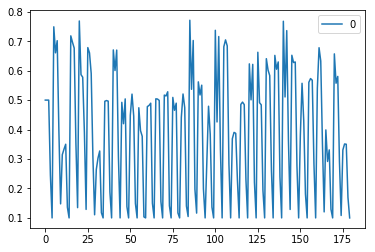

In [108]:
pd.DataFrame(prob.T).iloc[:,:1].plot()

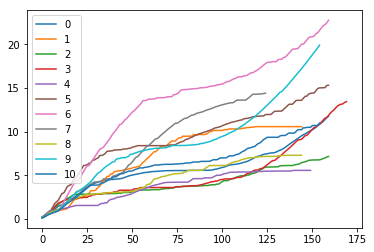

In [113]:
pd.DataFrame(np.load("C:/Users/isaac/Dropbox/Harvard 17-18 Senior/Thesis/Results/FirstIter/regret_simNum4799.npy").cumsum(axis=1).T).loc[:,:10].plot()

In [73]:
np.cumsum(regret,axis=1)

array([[ 0.18376932,  0.23285644,  0.4115708 , ...,         nan,
                nan,         nan],
       [ 0.04908712,  0.09817423,  0.14726135, ...,         nan,
                nan,         nan],
       [ 0.18882428,  0.37764856,  0.43179063, ...,         nan,
                nan,         nan],
       ..., 
       [ 0.05414207,  0.24296635,  0.42673567, ...,         nan,
                nan,         nan],
       [ 0.05414207,  0.24296635,  0.42673567, ...,         nan,
                nan,         nan],
       [ 0.18882428,  0.24296635,  0.43179063, ...,         nan,
                nan,         nan]])

In [ ]:

# # reward_exp, reward_0, reward_1, prob, action, fc_invoked, bandit_mean, bandit = run_simulation(coef0 = Thetas_fit[4:12], coef1 = Thetas_fit[0:4], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, f_baseline=f_baseline_identity, f_interact=f_interact_identity, reward_func = reward_func_identity, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed)
# reward_exp, reward_0, reward_1, prob, action, fc_invoked, bandit = run_simulation(coef0 = Thetas_fit[4:12], coef1 = Thetas_fit[0:4], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, f_baseline=f_baseline_identity, f_interact=f_interact_identity, reward_func = reward_func_identity, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed)

In [2]:
import numpy as np
import yaml
from itertools import product

k = 3

overall_seed = 2018
overall_seed_state = np.random.RandomState(overall_seed)

# batch_nums = [1]
# sig2_mults = [0.5,1.,2.]
# prior_cov_mults = [0.25,1.,4.]
# gammas = [0.6,0.8,0.9,0.99]
# lambs = [0.1,1.,10.]
# N_c_mults = [0.25,0.5]
# T_cs = [5, 10, 20]

#DEEP SCAN VALUES
batch_nums = list(range(k))
sig2_mults = [0.5,1.,2.]
prior_cov_mults = [0.1,0.5,1.,2.]
gammas = [0.8,0.9,0.99,1.]
lambs = [0.1,0.5, 1.,2.]
N_c_mults = [0.25, 0.5,0.75]
T_cs = [5, 10, 20]

sim_count = len(batch_nums)*len(sig2_mults)*len(prior_cov_mults)*len(gammas)*len(lambs)*len(N_c_mults)*len(T_cs)


split_seeds = np.array([[split_seed] * int(sim_count / k) for split_seed in overall_seed_state.randint(2**31, size = k)]).flatten()
sim_seeds = overall_seed_state.randint(2**31, size = sim_count)

In [3]:
sim_num = 0
out_dir = "results/"
data_loc_pref = "../../../Data/"
param_loc = "yamls/"

# Load parameters
with open(param_loc + "/params" + str(sim_num) + ".yaml") as f:
    params = yaml.load(f)

locals().update(params)


# Generative Model fit

def f_baseline_identity(featVec):
    return featVec

def f_interact_identity(featVec):
    return featVec[...,:4]

#Create a reward function from true coefficients, with residuals non-mandatory
def reward_func_general(S, A, coef0, coef1, f_baseline, f_interact, resid = None):
    '''Generalized reward function, can edit for different generative models.
    Works for multidimensional eta, a, and s, so long as they are of same multidimension.
    Assumes s has first element as bias for the regression.
    
    Resid must be passed in if not single dim.
    If single dim, can speed out without np.take.'''
    
    
    predictors = np.concatenate([A * f_interact(S), f_baseline(S)], 0)
    
    Theta = np.concatenate([coef1, coef0])
    
    if resid is None:
        resid = 0
        
    return(resid + np.dot(predictors, Theta))



## Creating Simulations



# Counts from HS 1
N_data = 48 # users indexed up to 48, but true count is 37
N = 37
T = 42
t = 5
nBaseline = 1+7
nInteract = 1+3 # Add 1 for bias term

N_sim = 50
T_new = 90

# start = datetime.datetime.now()

S, R, A = read_data(N_data, T, t, nBaseline, data_loc_pref)



In [71]:


# ###############
# ## Non-split ##
# ###############
# resids, Thetas_fit, resid_model = resid_regression(N, T, t, nBaseline, nInteract, f_baseline_identity, f_interact_identity, R, A, S)
# resids_new, A_new, S_new = sample_sim_users(resids, A, S, N_sim, T, t)
# I_new = np.expand_dims(~np.isnan(S_new).any(axis=-1),-1).astype(int) #



# resid_sig2 = np.nanvar(resids)
# prior_mean = Thetas_fit



# prior_mdl = model(np.expand_dims(prior_mean,1), np.eye(nInteract+nBaseline) * prior_cov_mult)
# fc_params = [lamb, int(N_c_mult*T_c), T_c]


# # sim_start = datetime.datetime.now()
# # reward_exp, reward_0, reward_1, prob, action, fc_invoked, bandit_mean, bandit = run_simulation(coef0 = Thetas_fit[4:12], coef1 = Thetas_fit[0:4], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, f_baseline=f_baseline_identity, f_interact=f_interact_identity, reward_func = reward_func_identity, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed)
# reward_exp, reward_0, reward_1, prob, action, fc_invoked, bandit = run_simulation(coef0 = Thetas_fit[4:12], coef1 = Thetas_fit[0:4], S_sim = S_new, I_sim = I_new, resids_sim = resids_new, f_baseline=f_baseline_identity, f_interact=f_interact_identity, reward_func = reward_func_identity, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed)



##################################
## Split train and test batches ##
##################################
train_zip, test_zip = k_fold_split(S,R,A,k,seed = split_seed) ## Seed for split

S_train,R_train,A_train = train_zip[batch_num]


resids_train, Thetas_fit_train, resid_model_train = resid_regression(S_train.shape[0], T, t, nBaseline, nInteract, f_baseline_identity, f_interact_identity, R_train.squeeze(), A_train, S_train)
resids_new_train, A_new_train, S_new_train = sample_sim_users(resids_train, A_train, S_train, N_sim, T, t)
I_new_train = np.expand_dims(~np.isnan(S_new_train).any(axis=-1),-1).astype(int) #

if train:
    resid_sig2 = np.nanvar(resids_train)
    prior_mean = np.zeros_like(Thetas_fit_train)


prior_mdl = model(np.expand_dims(prior_mean,1), np.eye(nInteract+nBaseline) * prior_cov_mult)
fc_params = [lamb, int(N_c_mult*T_c), T_c]

In [75]:

reward_exp, prob, action, fc_invoked, bandit = run_simulation(coef0 = Thetas_fit_train[4:12], coef1 = Thetas_fit_train[0:4], S_sim = S_new_train, I_sim = I_new_train, resids_sim = resids_new_train, f_baseline=f_baseline_identity, f_interact=f_interact_identity, reward_func = reward_func_identity, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed)

In [ ]:

reward_exp2, prob2, action2, fc_invoked2, bandit = run_simulation(coef0 = Thetas_fit_train[4:12], coef1 = Thetas_fit_train[0:4], S_sim = S_new_train, I_sim = I_new_train, resids_sim = resids_new_train, f_baseline=f_baseline_identity, f_interact=f_interact_identity, reward_func = reward_func_identity, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed, pc_flag=False)

In [130]:
a = "results/"

'111results'

In [ ]:
flags = ()

In [126]:
[i for i in product([True, False],[True, False],[True, False])]

[(True, True, True),
 (True, True, False),
 (True, False, True),
 (True, False, False),
 (False, True, True),
 (False, True, False),
 (False, False, True),
 (False, False, False)]

In [ ]:



# sim_start = datetime.datetime.now()
# reward_exp, reward_0, reward_1, prob, action, fc_invoked, bandit_mean, bandit = run_simulation(coef0 = Thetas_fit_train[4:12], coef1 = Thetas_fit_train[0:4], S_sim = S_new_train, I_sim = I_new_train, resids_sim = resids_new_train, f_baseline=f_baseline_identity, f_interact=f_interact_identity, reward_func = reward_func_identity, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed)

reward_exp, prob, action, fc_invoked, bandit = run_simulation(coef0 = Thetas_fit_train[4:12], coef1 = Thetas_fit_train[0:4], S_sim = S_new_train, I_sim = I_new_train, resids_sim = resids_new_train, f_baseline=f_baseline_identity, f_interact=f_interact_identity, reward_func = reward_func_identity, fc_params = fc_params, prior_model = prior_mdl, gamma = gamma, sigma2 = resid_sig2*sig2_mult, seed=sim_seed)



#################
## Output Data ##
#################

# datNames = ["reward_exp","reward_0","reward_1","prob","action","fc_invoked","bandit_mean"]
# dats = [reward_exp,reward_0,reward_1,prob,action,fc_invoked,bandit_mean]

# Without bandit_mean
datNames = ["reward_exp","prob","action","fc_invoked"]
dats = [reward_exp,prob,action,fc_invoked]

for dat, datName in zip(dats, datNames):
    np.save(out_dir + datName + "_simNum" + str(sim_num) + ".npy", dat)


#################
## Save Params ##
#################
if train:
    params["computed"] = True
    params["prior_mean"] = prior_mean.tolist()
    params["resid_sig2"] = float(resid_sig2)
    params["train"] = False
    with open(param_loc + "/params" + str(sim_num) + ".yaml", "w") as f:
        yaml.dump(params, f)


In [ ]:
R_s